In [ ]:
# CELL 1: SETUP - Define Functions and Constants
# ============================================================

import numpy as np
import nibabel as nib
import pandas as pd
from pathlib import Path
from scipy.ndimage import label, center_of_mass
from scipy.stats import pearsonr, ttest_ind

# Paths
BASE_DIR = Path('/user_data/csimmon2/long_pt')
RESULTS_CSV = '/user_data/csimmon2/git_repos/long_pt/B_analyses/results.csv'
OUTPUT_CSV = '/user_data/csimmon2/git_repos/long_pt/B_analyses/results_final.csv'

# Contrast definitions
COPE_MAP_DIFFERENTIAL = {
    'face': (10, 1),   # Face > Scramble
    'word': (13, -1),  # Face > Word inverted → Word > Face
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

COPE_MAP_SCRAMBLE = {
    'face': (10, 1),   # Face > Scramble
    'word': (12, 1),   # Word > Scramble
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

def create_sphere(center_coord, affine, brain_shape, radius=6):
    """Create spherical ROI mask around coordinate"""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - center_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

print("✓ Setup complete")

✓ Setup complete


In [43]:
# CELL 2: EXTRACTION - Top 20% ROI Extraction (Both Contrast Sets)
# ============================================================

def extract_top20_rois(subject_id, cope_map, percentile=80, min_cluster_size=20):
    """Extract ROIs using top 20% of voxels within search mask"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): 
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, (cope_num, multiplier) in cope_map.items():
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): 
                continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except: 
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): 
                    continue
                
                try:
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    pos_voxels = z_full[search_mask & (z_full > 0)]
                    
                    if len(pos_voxels) < min_cluster_size: 
                        continue
                    
                    dynamic_thresh = max(np.percentile(pos_voxels, percentile), 1.64)
                    
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0: 
                        continue
                    
                    # Select largest cluster
                    best_idx, max_size = -1, 0
                    for i in range(1, n_clusters + 1):
                        size = np.sum(labeled == i)
                        if size > max_size:
                            max_size = size
                            best_idx = i
                    
                    if best_idx == -1 or max_size < min_cluster_size: 
                        continue
                    
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': z_full[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'threshold': dynamic_thresh
                    }
                except Exception as e:
                    print(f"Error {subject_id} {hemi_key} ses-{session}: {e}")
                    
    return all_results

# Extract for BOTH contrast sets
print("Extracting Top 20% ROIs - DIFFERENTIAL...")
top20_differential = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top20_rois(sub, COPE_MAP_DIFFERENTIAL)
    if res: 
        top20_differential[sub] = res
print(f"✓ Differential: {len(top20_differential)} subjects")

print("\nExtracting Top 20% ROIs - SCRAMBLE...")
top20_scramble = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top20_rois(sub, COPE_MAP_SCRAMBLE)
    if res: 
        top20_scramble[sub] = res
print(f"✓ Scramble: {len(top20_scramble)} subjects")

Extracting Top 20% ROIs - DIFFERENTIAL...
✓ Differential: 23 subjects

Extracting Top 20% ROIs - SCRAMBLE...
✓ Scramble: 23 subjects


In [44]:
# CELL 3: SPATIAL RELOCATION (Drift) - Both Contrast Sets
# ============================================================

def compute_spatial_relocation(functional_results, subjects_dict):
    """
    Compute Spatial Relocation (Drift)
    - Euclidean distance between T1 and T2 centroids
    - Higher values = more physical movement
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            c1 = sessions_data[sessions[0]]['centroid']
            c2 = sessions_data[sessions[-1]]['centroid']
            drift = np.linalg.norm(np.array(c2) - np.array(c1))
            
            # Flag weak signal (T1 peak z < 2.3)
            t1_z = sessions_data[sessions[0]]['peak_z']
            flag = 'WEAK_SIGNAL' if t1_z < 2.3 else ''
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            results.append({
                'subject': sid,
                'code': info.get('code', sid),
                'group': info.get('group', 'unknown'),
                'hemi': hemi,
                'category': category,
                'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                'spatial_relocation_mm': drift,
                'flag': flag
            })
    
    return pd.DataFrame(results)

# Compute for both contrast sets
print("Computing Spatial Relocation...")
drift_differential = compute_spatial_relocation(top20_differential, ANALYSIS_SUBJECTS)
drift_scramble = compute_spatial_relocation(top20_scramble, ANALYSIS_SUBJECTS)

print(f"\nDIFFERENTIAL Summary:")
print(drift_differential.groupby(['group', 'category_type'])['spatial_relocation_mm'].agg(['mean', 'std', 'count']))

print(f"\nSCRAMBLE Summary (for supplementary):")
print(drift_scramble.groupby(['group', 'category_type'])['spatial_relocation_mm'].agg(['mean', 'std', 'count']))

Computing Spatial Relocation...

DIFFERENTIAL Summary:
                            mean        std  count
group   category_type                             
OTC     Bilateral       7.793372   5.975863     10
        Unilateral     13.336684  13.136469     10
control Bilateral       5.441073   7.067455     36
        Unilateral      5.784939   8.114254     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      5.244716   6.506233     18

SCRAMBLE Summary (for supplementary):
                            mean        std  count
group   category_type                             
OTC     Bilateral       7.793372   5.975863     10
        Unilateral     16.774726  15.740054     10
control Bilateral       5.441073   7.067455     36
        Unilateral      6.628637   7.938228     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      6.820326  11.128870     18


In [45]:
# CELL 4: GEOMETRY PRESERVATION - RDM Stability (6mm, 8mm, 10mm spheres)
# ============================================================

def compute_geometry_preservation(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute Geometry Preservation (RDM Stability)
    - Dynamic sphere at each session's centroid
    - Correlation of 4-category RDM between T1 and T2
    - Lower values = more representational change
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in ['face', 'object', 'house', 'word']:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            
            # Dynamic spheres at each session's centroid
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in ['face', 'word', 'object', 'house']:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    rdm = 1 - np.corrcoef(patterns)
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) == 2:
                triu_idx = np.triu_indices(4, k=1)
                r, _ = pearsonr(rdms[first_ses][triu_idx], rdms[last_ses][triu_idx])
                
                hemi = roi_key.split('_')[0]
                category = roi_key.split('_')[1]
                
                results.append({
                    'subject': sid,
                    'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'),
                    'hemi': hemi,
                    'category': category,
                    'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                    'geometry_preservation': r
                })
    
    return pd.DataFrame(results)

# Compute for 6mm, 8mm, 10mm
print("Computing Geometry Preservation...")
geometry_results = {}
for radius in [6, 8, 10]:
    geometry_results[radius] = compute_geometry_preservation(
        top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius
    )
    print(f"  {radius}mm: {len(geometry_results[radius])} ROIs")
print("✓ Done")

Computing Geometry Preservation...
  6mm: 128 ROIs
  8mm: 128 ROIs
  10mm: 128 ROIs
✓ Done


In [46]:
# CELL 5: ANCHORED STABILITY - Pattern at Fixed T1 Location
# ============================================================

def compute_anchored_stability(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute Anchored Stability
    - Sphere at T1 centroid ONLY (anchored/fixed location)
    - Pattern correlation T1↔T2 at same location
    - Low values in OTC indicate functional region has relocated
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in ['face', 'object', 'house', 'word']:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            
            # ANCHORED: sphere at T1 centroid only
            sphere = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            
            category = roi_key.split('_')[1]
            cope_num, mult = cope_map[category]
            
            patterns = {}
            for ses in [first_ses, last_ses]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    continue
                
                data = nib.load(cope_file).get_fdata() * mult
                pattern = data[sphere]
                
                if len(pattern) > 0 and np.all(np.isfinite(pattern)):
                    patterns[ses] = pattern
            
            if len(patterns) == 2:
                try:
                    r, _ = pearsonr(patterns[first_ses], patterns[last_ses])
                    
                    hemi = roi_key.split('_')[0]
                    
                    results.append({
                        'subject': sid,
                        'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'),
                        'hemi': hemi,
                        'category': category,
                        'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                        'anchored_stability': r
                    })
                except:
                    continue
    
    return pd.DataFrame(results)

# Compute
print("Computing Anchored Stability (6mm)...")
anchored_results = compute_anchored_stability(
    top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius=6
)
print(f"✓ Done: {len(anchored_results)} ROIs")

Computing Anchored Stability (6mm)...
✓ Done: 128 ROIs


In [47]:
# CELL 6: STATISTICS SUMMARY - All Measures
# ============================================================

def print_summary(df, measure_col, measure_name, higher_means_more_change=True):
    """Print summary statistics for a measure"""
    
    direction = "higher=more change" if higher_means_more_change else "lower=more change"
    print(f"\n{measure_name} ({direction})")
    print("-" * 70)
    
    for group in ['OTC', 'nonOTC', 'control']:
        group_data = df[df['group'] == group]
        bil = group_data[group_data['category_type'] == 'Bilateral'][measure_col]
        uni = group_data[group_data['category_type'] == 'Unilateral'][measure_col]
        
        if len(bil) > 1 and len(uni) > 1:
            t, p = ttest_ind(bil, uni)
            gap = bil.mean() - uni.mean()
            
            # Determine if supports hypothesis (bilateral > change in OTC)
            if higher_means_more_change:
                supports = "✓" if (gap > 0 and group == 'OTC' and p < 0.05) else ""
            else:
                supports = "✓" if (gap < 0 and group == 'OTC' and p < 0.05) else ""
            
            print(f"  {group:<8}: Bil={bil.mean():.3f}±{bil.sem():.3f} (n={len(bil)}), "
                  f"Uni={uni.mean():.3f}±{uni.sem():.3f} (n={len(uni)}), "
                  f"Gap={gap:+.3f}, p={p:.4f} {supports}")

print("="*70)
print("RESULTS SUMMARY - All Measures")
print("="*70)

# Spatial Relocation (higher = more movement)
print_summary(drift_differential, 'spatial_relocation_mm', 
              'SPATIAL RELOCATION (mm)', higher_means_more_change=True)

# Geometry Preservation (lower = more change)
print_summary(geometry_results[6], 'geometry_preservation', 
              'GEOMETRY PRESERVATION (6mm)', higher_means_more_change=False)

# Anchored Stability (lower = region moved away from anchor)
print_summary(anchored_results, 'anchored_stability',
              'ANCHORED STABILITY (6mm)', higher_means_more_change=False)

print("\n" + "="*70)
print("NOTE: Selectivity Change (Liu) computed separately - see results.csv")
print("="*70)

RESULTS SUMMARY - All Measures

SPATIAL RELOCATION (mm) (higher=more change)
----------------------------------------------------------------------
  OTC     : Bil=7.793±1.890 (n=10), Uni=13.337±4.154 (n=10), Gap=-5.543, p=0.2402 
  nonOTC  : Bil=3.419±0.533 (n=18), Uni=5.245±1.534 (n=18), Gap=-1.826, p=0.2686 
  control : Bil=5.441±1.178 (n=36), Uni=5.785±1.352 (n=36), Gap=-0.344, p=0.8485 

GEOMETRY PRESERVATION (6mm) (lower=more change)
----------------------------------------------------------------------
  OTC     : Bil=0.433±0.119 (n=10), Uni=0.723±0.049 (n=10), Gap=-0.290, p=0.0366 ✓
  nonOTC  : Bil=0.726±0.061 (n=18), Uni=0.762±0.046 (n=18), Gap=-0.036, p=0.6408 
  control : Bil=0.659±0.060 (n=36), Uni=0.755±0.035 (n=36), Gap=-0.096, p=0.1733 

ANCHORED STABILITY (6mm) (lower=more change)
----------------------------------------------------------------------
  OTC     : Bil=0.501±0.092 (n=10), Uni=0.302±0.139 (n=10), Gap=+0.199, p=0.2456 
  nonOTC  : Bil=0.884±0.016 (n=18), Uni

In [48]:
# CELL 7: MERGE AND SAVE CSV
# ============================================================

# Load original CSV
df = pd.read_csv(RESULTS_CSV)
print(f"Original CSV: {len(df)} rows")

# Rename existing columns to new naming scheme
rename_existing = {
    'Liu_Distinctiveness': 'Selectivity_Change',
    'RDM_Stability': 'Geometry_Preservation_old',
    'Hybrid_Stability': 'Anchored_Stability_old',
    'Spatial_Drift_mm': 'Spatial_Relocation_mm_old'
}
df = df.rename(columns={k: v for k, v in rename_existing.items() if k in df.columns})

# Create merge helper function
def get_merge_hemi(row):
    if pd.notna(row.get('nonpt_hemi')):
        return row['nonpt_hemi'].upper()
    elif pd.notna(row.get('Intact_Hemisphere')):
        return str(row['Intact_Hemisphere'])[0].upper()
    return None

df['merge_hemi'] = df.apply(get_merge_hemi, axis=1)

# --- Merge Spatial Relocation ---
drift_df = drift_differential.copy()
drift_df['merge_key'] = drift_df['code'] + '_' + drift_df['hemi'].str.upper() + '_' + drift_df['category'].str.capitalize()
df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']

drift_df = drift_df.rename(columns={'spatial_relocation_mm': 'Spatial_Relocation_mm'})
df = df.merge(drift_df[['merge_key', 'Spatial_Relocation_mm']], on='merge_key', how='left')
df = df.drop(columns=['merge_key'])
print(f"Spatial_Relocation_mm: {df['Spatial_Relocation_mm'].notna().sum()}/{len(df)} values")

# --- Merge Geometry Preservation (6mm, 8mm, 10mm) ---
for radius in [6, 8, 10]:
    geom_df = geometry_results[radius].copy()
    geom_df['merge_key'] = geom_df['code'] + '_' + geom_df['hemi'].str.upper() + '_' + geom_df['category'].str.capitalize()
    df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']
    
    col_name = f'Geometry_Preservation_{radius}mm'
    geom_df = geom_df.rename(columns={'geometry_preservation': col_name})
    
    df = df.merge(geom_df[['merge_key', col_name]], on='merge_key', how='left')
    df = df.drop(columns=['merge_key'])
    print(f"{col_name}: {df[col_name].notna().sum()}/{len(df)} values")

# --- Merge Anchored Stability (6mm) ---
anch_df = anchored_results.copy()
anch_df['merge_key'] = anch_df['code'] + '_' + anch_df['hemi'].str.upper() + '_' + anch_df['category'].str.capitalize()
df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']

anch_df = anch_df.rename(columns={'anchored_stability': 'Anchored_Stability_6mm'})
df = df.merge(anch_df[['merge_key', 'Anchored_Stability_6mm']], on='merge_key', how='left')
df = df.drop(columns=['merge_key', 'merge_hemi'])
print(f"Anchored_Stability_6mm: {df['Anchored_Stability_6mm'].notna().sum()}/{len(df)} values")

# Save
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✓ Saved to: {OUTPUT_CSV}")
print(f"Final shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Original CSV: 127 rows
Spatial_Relocation_mm: 127/127 values
Geometry_Preservation_6mm: 127/127 values
Geometry_Preservation_8mm: 127/127 values
Geometry_Preservation_10mm: 127/127 values
Anchored_Stability_6mm: 127/127 values

✓ Saved to: /user_data/csimmon2/git_repos/long_pt/B_analyses/results_final.csv
Final shape: (127, 20)

Columns: ['Subject', 'Group', 'Surgery_Side', 'Intact_Hemisphere', 'Sex', 'nonpt_hemi', 'Category', 'Category_Type', 'Anchored_Stability_old', 'Spatial_Relocation_mm_old', 'Geometry_Preservation_old', 'Selectivity_Change', 'age_1', 'age_2', 'scan_gap_years', 'Spatial_Relocation_mm', 'Geometry_Preservation_6mm', 'Geometry_Preservation_8mm', 'Geometry_Preservation_10mm', 'Anchored_Stability_6mm']


In [49]:
# CELL 8: VERIFY FINAL CSV
# ============================================================

df = pd.read_csv(OUTPUT_CSV)

print("FINAL CSV VERIFICATION")
print("="*70)

print(f"\nRows: {len(df)}")
print(f"\nRows per group:")
print(df['Group'].value_counts())

print(f"\nMeasure coverage:")
measures = ['Selectivity_Change', 'Spatial_Relocation_mm', 
            'Geometry_Preservation_6mm', 'Anchored_Stability_6mm']
for m in measures:
    if m in df.columns:
        coverage = df[m].notna().sum()
        print(f"  {m}: {coverage}/{len(df)}")

print(f"\nSample OTC rows:")
print(df[df['Group'] == 'OTC'][['Subject', 'Category', 'Selectivity_Change', 
                                 'Geometry_Preservation_6mm', 'Anchored_Stability_6mm']].head(8).to_string())

FINAL CSV VERIFICATION

Rows: 127

Rows per group:
control    72
nonOTC     36
OTC        19
Name: Group, dtype: int64

Measure coverage:
  Selectivity_Change: 127/127
  Spatial_Relocation_mm: 127/127
  Geometry_Preservation_6mm: 127/127
  Anchored_Stability_6mm: 127/127

Sample OTC rows:
   Subject Category  Selectivity_Change  Geometry_Preservation_6mm  Anchored_Stability_6mm
0   OTC004     Face               0.218                   0.398036                0.356162
1   OTC004     Word               0.082                   0.779389               -0.398889
2   OTC004   Object               0.099                   0.415878                0.195040
3   OTC004    House               0.487                  -0.036636                0.715625
8   OTC008     Face               0.097                   0.782927                0.117432
9   OTC008   Object               0.748                   0.722327                0.287728
10  OTC008    House               0.035                   0.184886       

Generating Spatial Relocation Rose Plot...
Extracted 115 drift vectors
  OTC: 15
  nonOTC: 35
  Control: 65


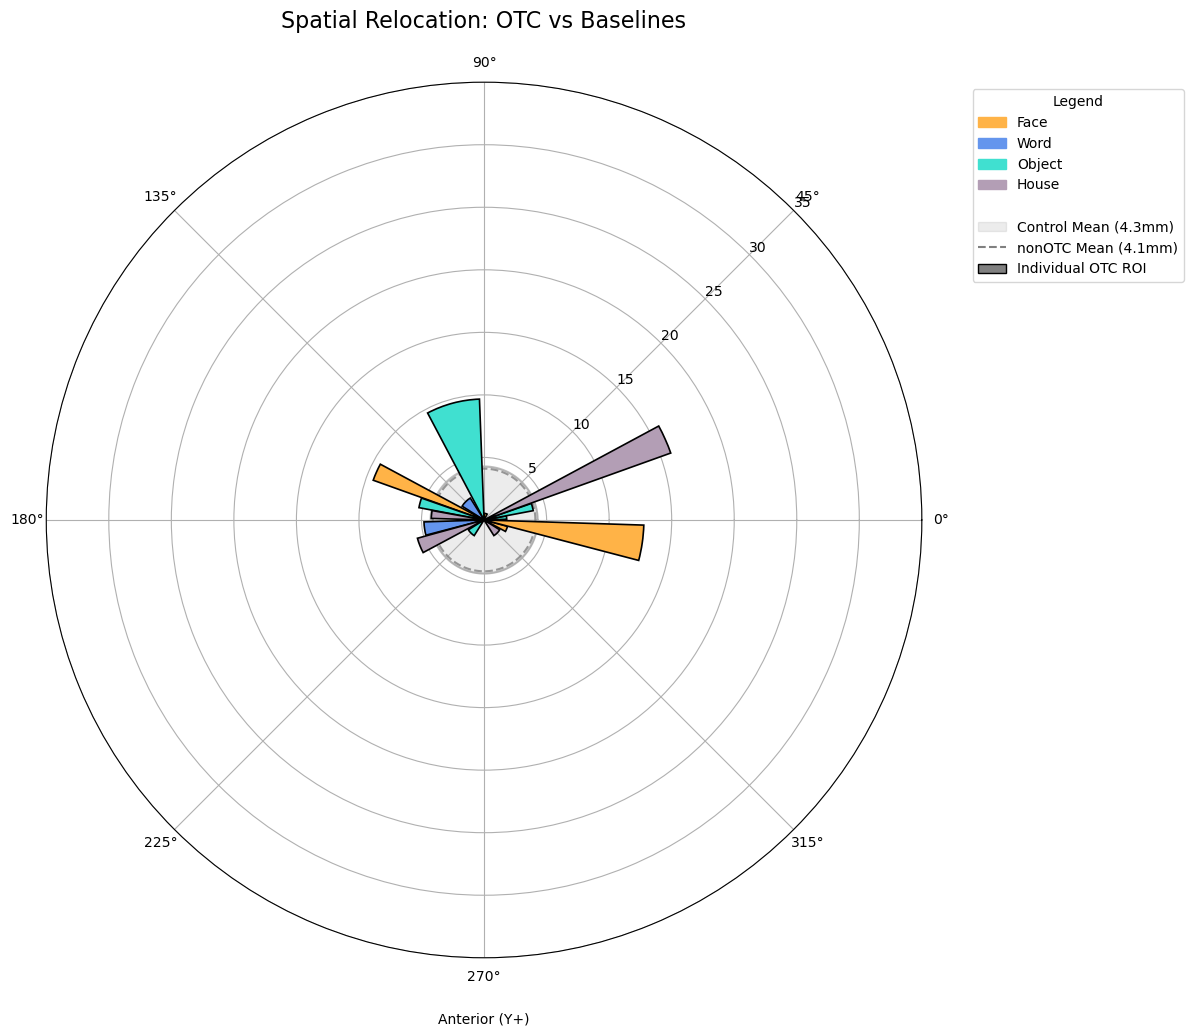

✓ Saved to /mnt/user-data/outputs/drift_rose_plot.png


In [55]:
# CELL 9: FIGURE - Polar Rose Plot of Spatial Relocation
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- CONFIGURATION ---
BIN_FILL_RATIO = 0.9  # How much of the 30-degree wedge to fill

# Pastel Palette
colors = {
    'face': '#FFB347',    # Pastel Peach
    'word': '#6495ED',    # Cornflower Blue
    'object': '#40E0D0',  # Turquoise
    'house': '#B39EB5'    # Pastel Purple
}
categories = ['face', 'word', 'object', 'house']

# --- HELPER FUNCTIONS ---
def cart2pol(y, z):
    """Convert cartesian to polar coordinates"""
    return np.arctan2(z, y), np.sqrt(y**2 + z**2)

def get_bin_index(angle, bin_edges, n_bins):
    """Get bin index for an angle"""
    return min(np.digitize(angle, bin_edges) - 1, n_bins - 1)

# --- EXTRACT DRIFT VECTORS ---
def extract_drift_vectors(results_dict, subjects_dict):
    """Extract drift vectors in polar coordinates"""
    data = []
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'control')
        if info.get('patient_status') == 'control': 
            group = 'control'
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: 
                continue
            
            s1 = sessions[sorted_ses[0]]
            s2 = sessions[sorted_ses[-1]]
            
            # Skip weak signal
            t1 = s1.get('threshold', s1.get('used_thresh', 0))
            t2 = s2.get('threshold', s2.get('used_thresh', 0))
            if t1 < 1.65 or t2 < 1.65: 
                continue
            
            c1 = s1['centroid']
            c2 = s2['centroid']
            dy = c2[1] - c1[1]  # Anterior-Posterior
            dz = c2[2] - c1[2]  # Superior-Inferior
            
            angle, radius = cart2pol(dy, dz)
            
            data.append({
                'Subject': sid, 
                'Group': group, 
                'Category': cat,
                'Radius': radius, 
                'Angle': angle,
                'Bin_Idx': get_bin_index(angle, bin_edges, N_BINS)
            })
            
    return pd.DataFrame(data)

# --- PLOTTING FUNCTION ---
def plot_drift_rose(df, title="Spatial Relocation: OTC vs Baselines"):
    """Plot polar rose diagram of drift vectors"""
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    full_bin_width = (2 * np.pi) / N_BINS
    
    # Global Baselines
    ctrl_mean = df[df['Group'] == 'control']['Radius'].mean()
    nonotc_mean = df[df['Group'] == 'nonOTC']['Radius'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 35)

    # 1. BASELINES (Gray Circles)
    theta = np.linspace(0, 2*np.pi, 100)
    ax.fill_between(theta, 0, ctrl_mean, color='gray', alpha=0.15, zorder=0)
    ax.plot(theta, [ctrl_mean]*100, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)
    ax.plot(theta, [nonotc_mean]*100, color='gray', linestyle='--', linewidth=1.5, alpha=0.8, zorder=2)

    # 2. OTC INDIVIDUALS (Dynamic Clustering)
    for b_idx in range(N_BINS):
        bin_center = bin_centers[b_idx]
        
        items = df[(df['Group'] == 'OTC') & (df['Bin_Idx'] == b_idx)].copy()
        
        if not items.empty:
            items['Cat_Sort'] = pd.Categorical(items['Category'], categories=categories, ordered=True)
            items = items.sort_values(['Cat_Sort', 'Radius'])
            
            n_items = len(items)
            total_usable_width = full_bin_width * BIN_FILL_RATIO
            individual_bar_width = total_usable_width / n_items
            cluster_start = bin_center - (total_usable_width / 2) + (individual_bar_width / 2)
            
            for k, (_, row) in enumerate(items.iterrows()):
                theta_pos = cluster_start + (k * individual_bar_width)
                ax.bar(theta_pos, row['Radius'], width=individual_bar_width * 0.95, bottom=0.0,
                       color=colors[row['Category']], alpha=1.0, edgecolor='black', 
                       linewidth=1.2, zorder=10)

    # Legend
    legend_cats = [mpatches.Patch(color=c, label=cat.title()) for cat, c in colors.items()]
    style_legend = [
        mpatches.Patch(facecolor='gray', alpha=0.15, edgecolor='gray', label=f'Control Mean ({ctrl_mean:.1f}mm)'),
        plt.Line2D([0], [0], color='gray', linestyle='--', label=f'nonOTC Mean ({nonotc_mean:.1f}mm)'),
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='Individual OTC ROI'),
    ]
    ax.legend(handles=legend_cats + [mpatches.Patch(visible=False)] + style_legend, 
              loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    
    plt.tight_layout()
    #plt.savefig('/mnt/user-data/outputs/drift_rose_plot.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved to /mnt/user-data/outputs/drift_rose_plot.png")

# --- EXECUTE ---
print("Generating Spatial Relocation Rose Plot...")
df_drift_vectors = extract_drift_vectors(top20_differential, ANALYSIS_SUBJECTS)
print(f"Extracted {len(df_drift_vectors)} drift vectors")
print(f"  OTC: {len(df_drift_vectors[df_drift_vectors['Group'] == 'OTC'])}")
print(f"  nonOTC: {len(df_drift_vectors[df_drift_vectors['Group'] == 'nonOTC'])}")
print(f"  Control: {len(df_drift_vectors[df_drift_vectors['Group'] == 'control'])}")

plot_drift_rose(df_drift_vectors)

Generating comparison bar plots...

✓ Saved to /mnt/user-data/outputs/selectivity_change_comparison.png


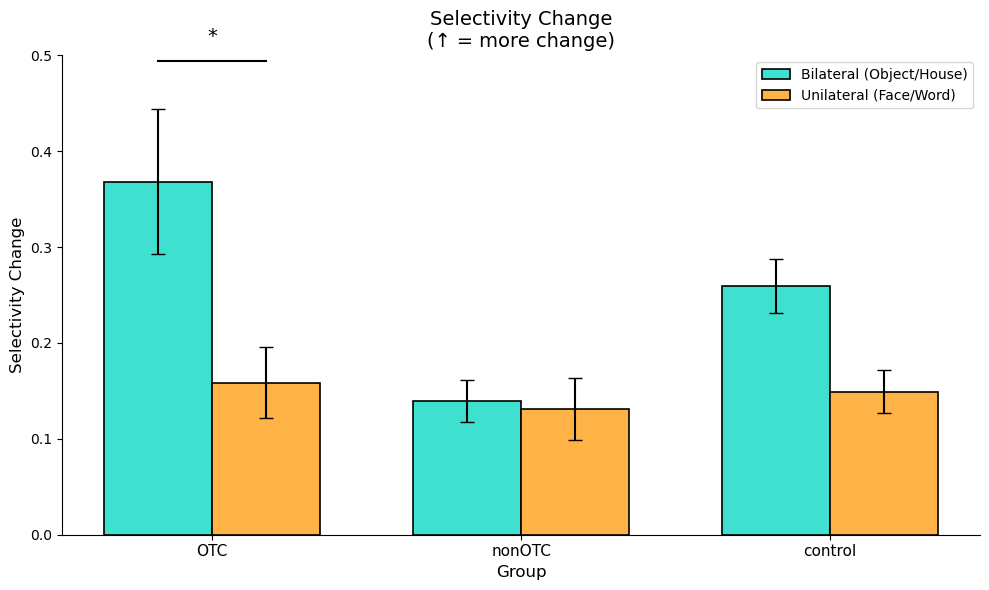

✓ Saved to /mnt/user-data/outputs/geometry_preservation_comparison.png


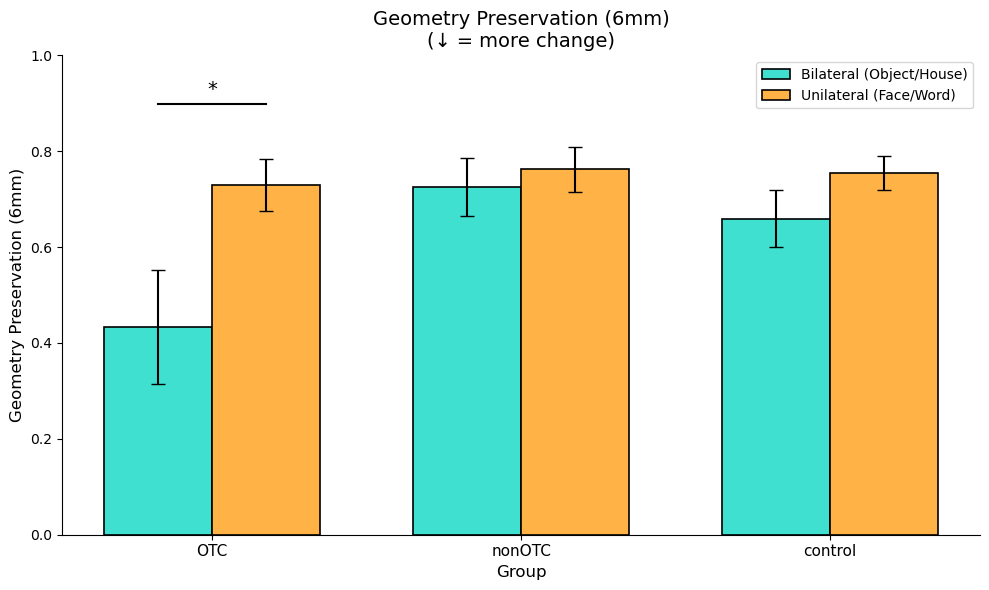

✓ Saved to /mnt/user-data/outputs/anchored_stability_comparison.png


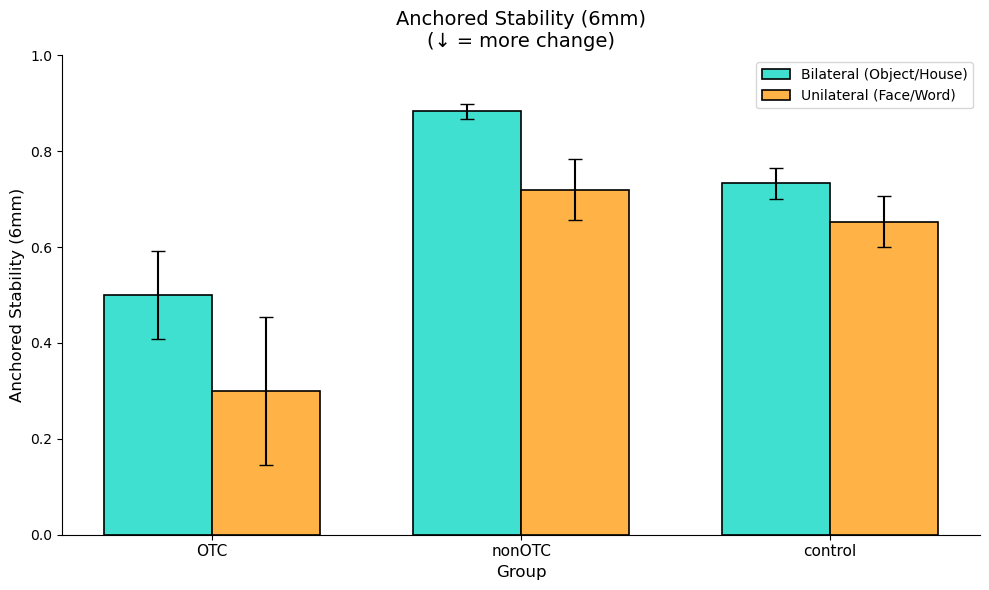

✓ Saved to /mnt/user-data/outputs/spatial_relocation_comparison.png


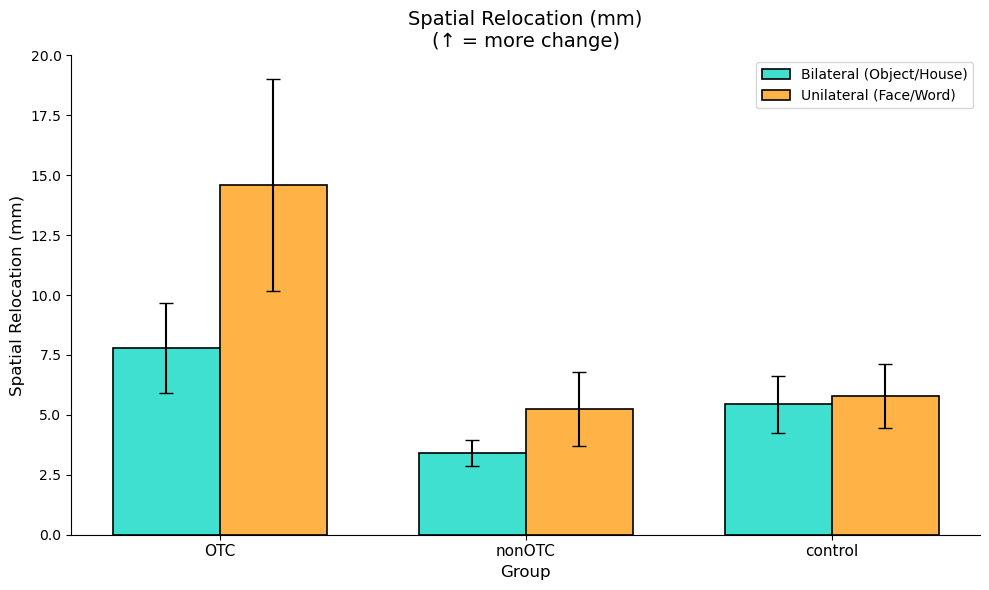

In [58]:
# CELL 10: FIGURE - Bar Plots: Bilateral vs Unilateral by Group
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

def plot_measure_comparison(df, measure_col, measure_name, higher_means_more_change=True, 
                            ylim=None, save_name=None):
    """
    Bar plot comparing Bilateral vs Unilateral across groups
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data
    plot_data = df.groupby(['Group', 'Category_Type'])[measure_col].agg(['mean', 'sem']).reset_index()
    plot_data.columns = ['Group', 'Category_Type', 'Mean', 'SEM']
    
    # Order groups
    group_order = ['OTC', 'nonOTC', 'control']
    plot_data['Group'] = pd.Categorical(plot_data['Group'], categories=group_order, ordered=True)
    plot_data = plot_data.sort_values('Group')
    
    # Colors
    cat_colors = {'Bilateral': '#40E0D0', 'Unilateral': '#FFB347'}
    
    # Plot
    x = np.arange(len(group_order))
    width = 0.35
    
    bil_data = plot_data[plot_data['Category_Type'] == 'Bilateral']
    uni_data = plot_data[plot_data['Category_Type'] == 'Unilateral']
    
    bars1 = ax.bar(x - width/2, bil_data['Mean'], width, yerr=bil_data['SEM'], 
                   label='Bilateral (Object/House)', color=cat_colors['Bilateral'],
                   capsize=5, edgecolor='black', linewidth=1.2)
    bars2 = ax.bar(x + width/2, uni_data['Mean'], width, yerr=uni_data['SEM'],
                   label='Unilateral (Face/Word)', color=cat_colors['Unilateral'],
                   capsize=5, edgecolor='black', linewidth=1.2)
    
    # Formatting
    ax.set_xlabel('Group', fontsize=12)
    ax.set_ylabel(measure_name, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(group_order, fontsize=11)
    ax.legend(loc='best', fontsize=10)
    
    direction = "↑ = more change" if higher_means_more_change else "↓ = more change"
    ax.set_title(f'{measure_name}\n({direction})', fontsize=14)
    
    if ylim:
        ax.set_ylim(ylim)
    
    # Add significance markers for OTC
    otc_bil = bil_data[bil_data['Group'] == 'OTC']['Mean'].values[0]
    otc_uni = uni_data[uni_data['Group'] == 'OTC']['Mean'].values[0]
    
    # Get p-value
    otc_df = df[df['Group'] == 'OTC']
    bil_vals = otc_df[otc_df['Category_Type'] == 'Bilateral'][measure_col].dropna()
    uni_vals = otc_df[otc_df['Category_Type'] == 'Unilateral'][measure_col].dropna()
    
    if len(bil_vals) > 1 and len(uni_vals) > 1:
        from scipy.stats import ttest_ind
        t, p = ttest_ind(bil_vals, uni_vals)
        
        if p < 0.05:
            max_y = max(otc_bil, otc_uni) + bil_data['SEM'].max() + 0.05
            ax.plot([x[0]-width/2, x[0]+width/2], [max_y, max_y], 'k-', linewidth=1.5)
            sig_text = '***' if p < 0.001 else '**' if p < 0.01 else '*'
            ax.text(x[0], max_y + 0.02, sig_text, ha='center', fontsize=14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    if save_name:
        #plt.savefig(f'/mnt/user-data/outputs/{save_name}.png', dpi=150, bbox_inches='tight')
        print(f"✓ Saved to /mnt/user-data/outputs/{save_name}.png")
    
    plt.show()

# Load final CSV
df = pd.read_csv(OUTPUT_CSV)

# Plot each measure
print("Generating comparison bar plots...\n")

# Selectivity Change (higher = more change) - if present
if 'Selectivity_Change' in df.columns:
    plot_measure_comparison(df, 'Selectivity_Change', 'Selectivity Change', 
                            higher_means_more_change=True, ylim=(0, 0.5),
                            save_name='selectivity_change_comparison')

# Geometry Preservation (lower = more change)
if 'Geometry_Preservation_6mm' in df.columns:
    plot_measure_comparison(df, 'Geometry_Preservation_6mm', 'Geometry Preservation (6mm)', 
                            higher_means_more_change=False, ylim=(0, 1.0),
                            save_name='geometry_preservation_comparison')

# Anchored Stability (lower = region moved)
if 'Anchored_Stability_6mm' in df.columns:
    plot_measure_comparison(df, 'Anchored_Stability_6mm', 'Anchored Stability (6mm)', 
                            higher_means_more_change=False, ylim=(0, 1.0),
                            save_name='anchored_stability_comparison')

# Spatial Relocation (higher = more movement)
if 'Spatial_Relocation_mm' in df.columns:
    plot_measure_comparison(df, 'Spatial_Relocation_mm', 'Spatial Relocation (mm)', 
                            higher_means_more_change=True, ylim=(0, 20),
                            save_name='spatial_relocation_comparison')

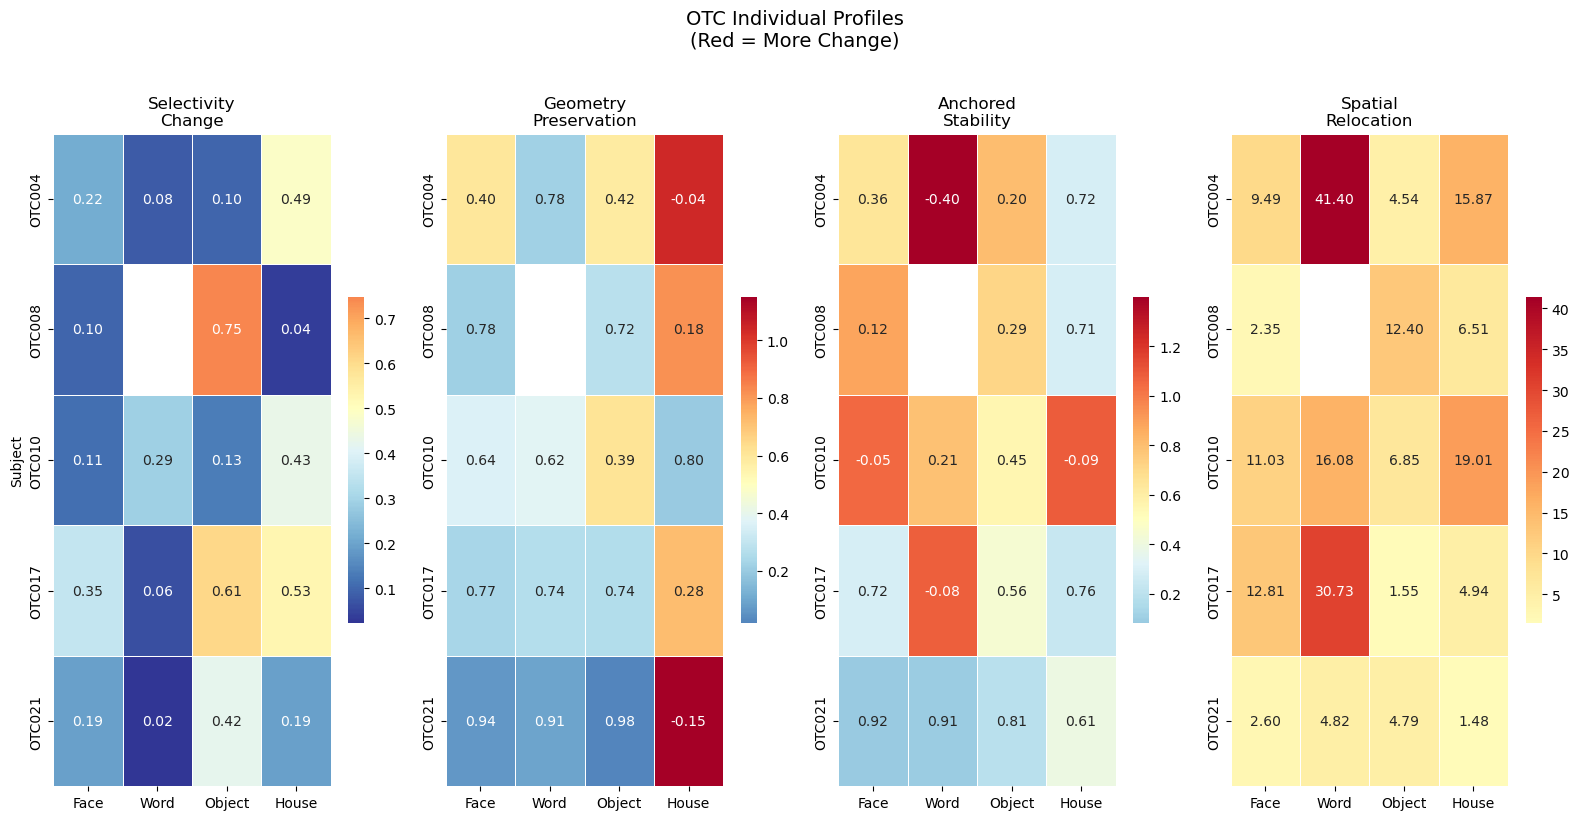

✓ Saved to /mnt/user-data/outputs/otc_individual_profiles.png


In [60]:
# CELL 11: FIGURE - Individual Subject Profiles (OTC Only)
# ============================================================

def plot_otc_individual_profiles(df):
    """
    Heatmap showing each OTC subject's measures by category
    """
    # Filter OTC
    otc_df = df[df['Group'] == 'OTC'].copy()
    
    # Measures to plot (invert geometry/anchored so higher = more change for all)
    measures = {
        'Selectivity_Change': ('Selectivity\nChange', False),  # Already higher = more change
        'Geometry_Preservation_6mm': ('Geometry\nPreservation', True),  # Invert: lower = more change
        'Anchored_Stability_6mm': ('Anchored\nStability', True),  # Invert: lower = more change
        'Spatial_Relocation_mm': ('Spatial\nRelocation', False)  # Already higher = more change
    }
    
    # Filter to available measures
    available = {k: v for k, v in measures.items() if k in df.columns}
    
    fig, axes = plt.subplots(1, len(available), figsize=(4*len(available), 8))
    if len(available) == 1:
        axes = [axes]
    
    for ax, (measure_col, (label, invert)) in zip(axes, available.items()):
        # Pivot for heatmap
        pivot = otc_df.pivot_table(index='Subject', columns='Category', 
                                    values=measure_col, aggfunc='mean')
        
        # Reorder categories
        cat_order = ['Face', 'Word', 'Object', 'House']
        pivot = pivot[[c for c in cat_order if c in pivot.columns]]
        
        # Invert if needed (so all heatmaps show "red = more change")
        plot_data = 1 - pivot if invert else pivot
        
        # Plot
        sns.heatmap(plot_data, ax=ax, cmap='RdYlBu_r', center=0.5 if not invert else 0.5,
                    annot=pivot.round(2), fmt='.2f', cbar_kws={'shrink': 0.5},
                    linewidths=0.5, linecolor='white')
        
        ax.set_title(label, fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Subject' if ax == axes[0] else '')
    
    plt.suptitle('OTC Individual Profiles\n(Red = More Change)', fontsize=14, y=1.02)
    plt.tight_layout()
    #plt.savefig('/mnt/user-data/outputs/otc_individual_profiles.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved to /mnt/user-data/outputs/otc_individual_profiles.png")

plot_otc_individual_profiles(df)

Generating category-level breakdowns...



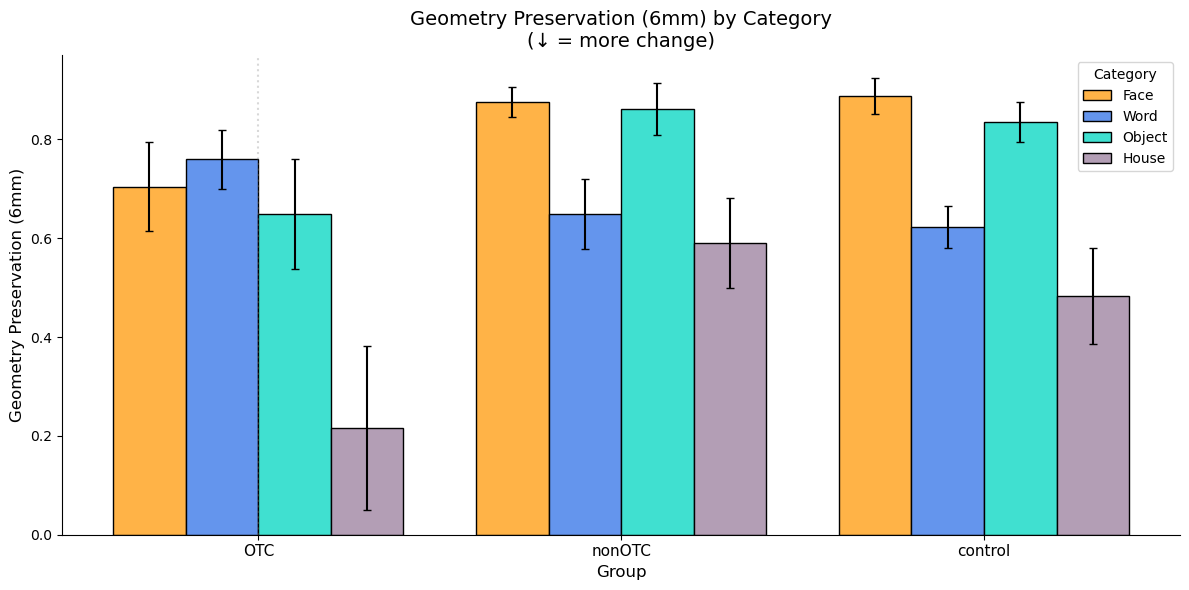

✓ Saved to /mnt/user-data/outputs/geometry_preservation_6mm_by_category.png


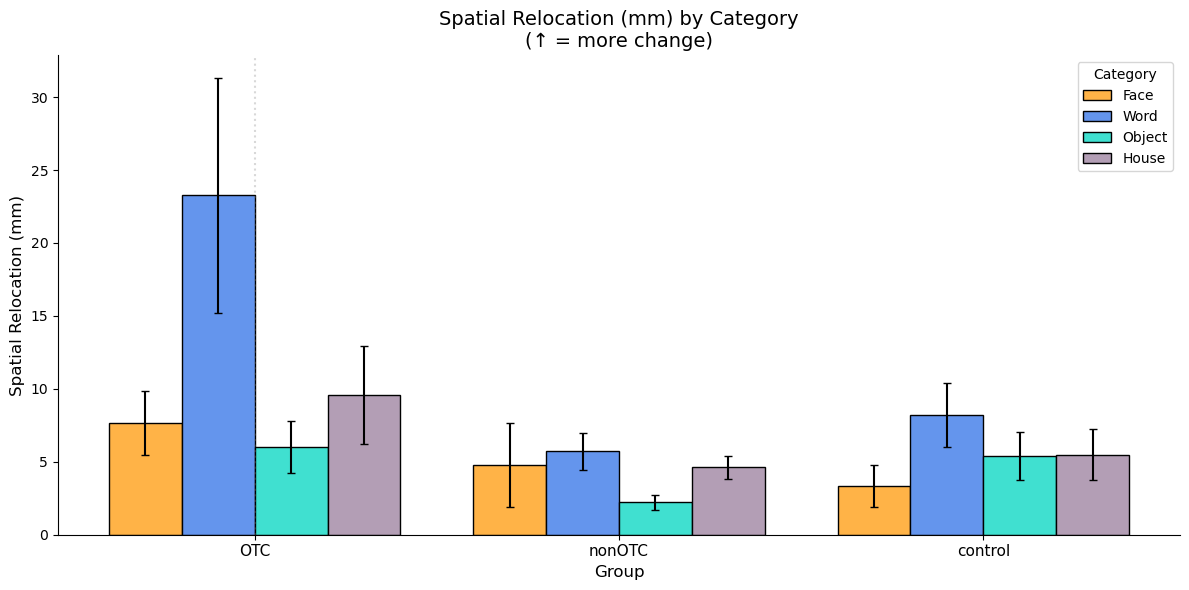

✓ Saved to /mnt/user-data/outputs/spatial_relocation_mm_by_category.png


In [61]:
# CELL 12: FIGURE - Category-Level Breakdown (4 Categories)
# ============================================================

def plot_category_breakdown(df, measure_col, measure_name, higher_means_more_change=True):
    """
    Bar plot showing all 4 categories separately for each group
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Colors per category
    cat_colors = {
        'Face': '#FFB347',    # Pastel Peach
        'Word': '#6495ED',    # Cornflower Blue
        'Object': '#40E0D0',  # Turquoise
        'House': '#B39EB5'    # Pastel Purple
    }
    
    # Prepare data
    plot_data = df.groupby(['Group', 'Category'])[measure_col].agg(['mean', 'sem']).reset_index()
    plot_data.columns = ['Group', 'Category', 'Mean', 'SEM']
    
    # Order
    group_order = ['OTC', 'nonOTC', 'control']
    cat_order = ['Face', 'Word', 'Object', 'House']
    
    x = np.arange(len(group_order))
    width = 0.2
    offsets = [-1.5, -0.5, 0.5, 1.5]
    
    for i, cat in enumerate(cat_order):
        cat_data = plot_data[plot_data['Category'] == cat].set_index('Group').reindex(group_order)
        ax.bar(x + offsets[i]*width, cat_data['Mean'], width, yerr=cat_data['SEM'],
               label=cat, color=cat_colors[cat], capsize=3, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('Group', fontsize=12)
    ax.set_ylabel(measure_name, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(group_order, fontsize=11)
    ax.legend(title='Category', loc='upper right')
    
    direction = "↑ = more change" if higher_means_more_change else "↓ = more change"
    ax.set_title(f'{measure_name} by Category\n({direction})', fontsize=14)
    
    # Add separator between bilateral/unilateral
    ax.axvline(x=x[0], color='gray', linestyle=':', alpha=0.3)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    save_name = measure_col.lower().replace('_', '_') + '_by_category'
    #plt.savefig(f'/mnt/user-data/outputs/{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to /mnt/user-data/outputs/{save_name}.png")

# Plot category breakdowns
print("Generating category-level breakdowns...\n")

if 'Geometry_Preservation_6mm' in df.columns:
    plot_category_breakdown(df, 'Geometry_Preservation_6mm', 'Geometry Preservation (6mm)', 
                            higher_means_more_change=False)

if 'Spatial_Relocation_mm' in df.columns:
    plot_category_breakdown(df, 'Spatial_Relocation_mm', 'Spatial Relocation (mm)', 
                            higher_means_more_change=True)

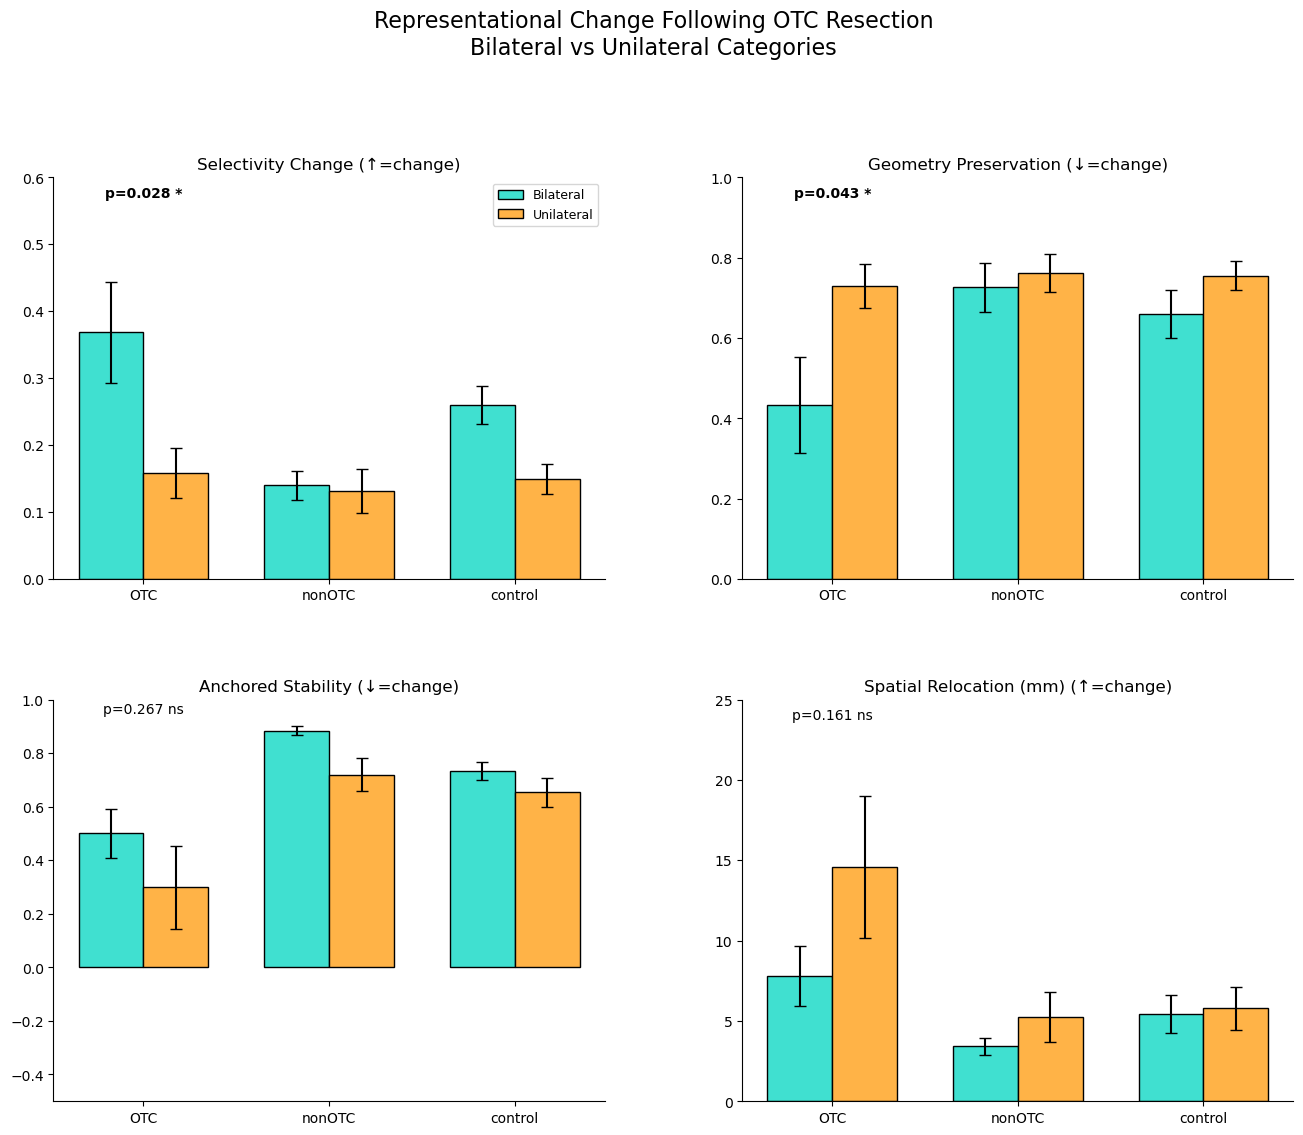

✓ Saved to /mnt/user-data/outputs/summary_dashboard.png


In [62]:
# CELL 13: FIGURE - Summary Dashboard
# ============================================================

def plot_summary_dashboard(df):
    """
    Multi-panel summary figure showing all key results
    """
    fig = plt.figure(figsize=(16, 12))
    
    # Define grid
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)
    
    measures = [
        ('Selectivity_Change', 'Selectivity Change', True, (0, 0.6)),
        ('Geometry_Preservation_6mm', 'Geometry Preservation', False, (0, 1.0)),
        ('Anchored_Stability_6mm', 'Anchored Stability', False, (-0.5, 1.0)),
        ('Spatial_Relocation_mm', 'Spatial Relocation (mm)', True, (0, 25))
    ]
    
    cat_colors = {'Bilateral': '#40E0D0', 'Unilateral': '#FFB347'}
    group_order = ['OTC', 'nonOTC', 'control']
    
    for idx, (measure_col, title, higher_change, ylim) in enumerate(measures):
        if measure_col not in df.columns:
            continue
            
        ax = fig.add_subplot(gs[idx // 2, idx % 2])
        
        plot_data = df.groupby(['Group', 'Category_Type'])[measure_col].agg(['mean', 'sem']).reset_index()
        plot_data.columns = ['Group', 'Category_Type', 'Mean', 'SEM']
        plot_data['Group'] = pd.Categorical(plot_data['Group'], categories=group_order, ordered=True)
        plot_data = plot_data.sort_values('Group')
        
        x = np.arange(len(group_order))
        width = 0.35
        
        bil_data = plot_data[plot_data['Category_Type'] == 'Bilateral']
        uni_data = plot_data[plot_data['Category_Type'] == 'Unilateral']
        
        ax.bar(x - width/2, bil_data['Mean'], width, yerr=bil_data['SEM'], 
               label='Bilateral', color=cat_colors['Bilateral'],
               capsize=4, edgecolor='black', linewidth=1)
        ax.bar(x + width/2, uni_data['Mean'], width, yerr=uni_data['SEM'],
               label='Unilateral', color=cat_colors['Unilateral'],
               capsize=4, edgecolor='black', linewidth=1)
        
        ax.set_xticks(x)
        ax.set_xticklabels(group_order)
        ax.set_ylim(ylim)
        
        direction = "↑" if higher_change else "↓"
        ax.set_title(f'{title} ({direction}=change)', fontsize=12)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=9)
        
        # Add p-value for OTC
        otc_df = df[df['Group'] == 'OTC']
        bil_vals = otc_df[otc_df['Category_Type'] == 'Bilateral'][measure_col].dropna()
        uni_vals = otc_df[otc_df['Category_Type'] == 'Unilateral'][measure_col].dropna()
        
        if len(bil_vals) > 1 and len(uni_vals) > 1:
            t, p = ttest_ind(bil_vals, uni_vals)
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
            ax.text(0, ylim[1]*0.95, f'p={p:.3f} {sig}', ha='center', fontsize=10, 
                    fontweight='bold' if p < 0.05 else 'normal')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.suptitle('Representational Change Following OTC Resection\nBilateral vs Unilateral Categories', 
                 fontsize=16, y=1.02)
    
    #plt.savefig('/mnt/user-data/outputs/summary_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved to /mnt/user-data/outputs/summary_dashboard.png")

plot_summary_dashboard(df)

In [68]:
# CELL: Selectivity Change by category (OTC)
print("SELECTIVITY CHANGE BY CATEGORY (OTC)")
print("="*50)

df = pd.read_csv(OUTPUT_CSV)
otc = df[df['Group'] == 'OTC']

for cat in ['Face', 'Word', 'Object', 'House']:
    vals = otc[otc['Category'] == cat]['Selectivity_Change'].dropna()
    print(f"{cat:<8}: {vals.mean():.3f} ± {vals.sem():.3f} (n={len(vals)})")

print("\n--- Pairwise ---")
face = otc[otc['Category'] == 'Face']['Selectivity_Change'].dropna().values
word = otc[otc['Category'] == 'Word']['Selectivity_Change'].dropna().values
obj = otc[otc['Category'] == 'Object']['Selectivity_Change'].dropna().values
house = otc[otc['Category'] == 'House']['Selectivity_Change'].dropna().values

print(f"Object vs Face: {obj.mean():.3f} vs {face.mean():.3f}, p={ttest_ind(obj, face)[1]:.3f}")
print(f"Object vs Word: {obj.mean():.3f} vs {word.mean():.3f}, p={ttest_ind(obj, word)[1]:.3f}")
print(f"House vs Face: {house.mean():.3f} vs {face.mean():.3f}, p={ttest_ind(house, face)[1]:.3f}")
print(f"House vs Word: {house.mean():.3f} vs {word.mean():.3f}, p={ttest_ind(house, word)[1]:.3f}")

SELECTIVITY CHANGE BY CATEGORY (OTC)
Face    : 0.194 ± 0.046 (n=5)
Word    : 0.115 ± 0.060 (n=4)
Object  : 0.403 ± 0.128 (n=5)
House   : 0.334 ± 0.095 (n=5)

--- Pairwise ---
Object vs Face: 0.403 vs 0.194, p=0.162
Object vs Word: 0.403 vs 0.115, p=0.104
House vs Face: 0.334 vs 0.194, p=0.220
House vs Word: 0.334 vs 0.115, p=0.109


In [69]:
# CELL: House ROI quality in OTC
print("HOUSE ROI QUALITY (OTC)")
print("="*50)

for sid, rois in top20_differential.items():
    info = ANALYSIS_SUBJECTS.get(sid, {})
    if info.get('group') != 'OTC':
        continue
    
    for roi_key, sessions in rois.items():
        if 'house' not in roi_key:
            continue
        
        for ses, data in sorted(sessions.items()):
            print(f"{info['code']} {roi_key} ses-{ses}: n={data['n_voxels']}, z={data['peak_z']:.2f}, thresh={data['threshold']:.2f}")

HOUSE ROI QUALITY (OTC)
OTC004 l_house ses-01: n=2206, z=5.25, thresh=1.84
OTC004 l_house ses-02: n=2210, z=9.42, thresh=2.06
OTC004 l_house ses-03: n=1993, z=11.75, thresh=2.74
OTC004 l_house ses-05: n=3498, z=12.23, thresh=2.76
OTC004 l_house ses-06: n=3495, z=12.64, thresh=3.03
OTC008 l_house ses-01: n=2570, z=8.53, thresh=3.11
OTC008 l_house ses-02: n=2057, z=7.24, thresh=1.85
OTC010 r_house ses-02: n=118, z=2.49, thresh=1.64
OTC010 r_house ses-03: n=232, z=2.92, thresh=1.64
OTC017 r_house ses-01: n=1698, z=10.32, thresh=2.96
OTC017 r_house ses-02: n=1023, z=5.39, thresh=2.16
OTC017 r_house ses-03: n=1635, z=5.60, thresh=1.85
OTC017 r_house ses-04: n=2105, z=11.39, thresh=2.76
OTC021 r_house ses-01: n=1207, z=5.41, thresh=2.06
OTC021 r_house ses-02: n=1349, z=8.78, thresh=2.58
OTC021 r_house ses-03: n=1766, z=10.40, thresh=3.03


In [70]:
# CELL: House stability across all groups
print("GEOMETRY PRESERVATION BY CATEGORY - ALL GROUPS")
print("="*60)

for group in ['OTC', 'nonOTC', 'control']:
    print(f"\n{group}:")
    group_data = geometry_results[6][geometry_results[6]['group'] == group]
    
    for cat in ['face', 'word', 'object', 'house']:
        vals = group_data[group_data['category'] == cat]['geometry_preservation']
        if len(vals) > 0:
            print(f"  {cat:<8}: {vals.mean():.3f} ± {vals.sem():.3f} (n={len(vals)})")

GEOMETRY PRESERVATION BY CATEGORY - ALL GROUPS

OTC:
  face    : 0.704 ± 0.090 (n=5)
  word    : 0.741 ± 0.051 (n=5)
  object  : 0.650 ± 0.111 (n=5)
  house   : 0.216 ± 0.166 (n=5)

nonOTC:
  face    : 0.875 ± 0.030 (n=9)
  word    : 0.649 ± 0.071 (n=9)
  object  : 0.861 ± 0.053 (n=9)
  house   : 0.591 ± 0.091 (n=9)

control:
  face    : 0.888 ± 0.036 (n=18)
  word    : 0.622 ± 0.042 (n=18)
  object  : 0.836 ± 0.041 (n=18)
  house   : 0.483 ± 0.097 (n=18)


In [71]:
# CELL: Is House uniquely unstable in OTC?
print("\nHOUSE STABILITY COMPARISON ACROSS GROUPS")
print("="*60)

otc_house = geometry_results[6][(geometry_results[6]['group'] == 'OTC') & 
                                 (geometry_results[6]['category'] == 'house')]['geometry_preservation']
nonotc_house = geometry_results[6][(geometry_results[6]['group'] == 'nonOTC') & 
                                    (geometry_results[6]['category'] == 'house')]['geometry_preservation']
ctrl_house = geometry_results[6][(geometry_results[6]['group'] == 'control') & 
                                  (geometry_results[6]['category'] == 'house')]['geometry_preservation']

print(f"OTC House:     {otc_house.mean():.3f} ± {otc_house.sem():.3f} (n={len(otc_house)})")
print(f"nonOTC House:  {nonotc_house.mean():.3f} ± {nonotc_house.sem():.3f} (n={len(nonotc_house)})")
print(f"Control House: {ctrl_house.mean():.3f} ± {ctrl_house.sem():.3f} (n={len(ctrl_house)})")

print("\n--- Group comparisons for House ---")
t1, p1 = ttest_ind(otc_house, nonotc_house)
t2, p2 = ttest_ind(otc_house, ctrl_house)
print(f"OTC vs nonOTC: t={t1:.2f}, p={p1:.3f}")
print(f"OTC vs Control: t={t2:.2f}, p={p2:.3f}")


HOUSE STABILITY COMPARISON ACROSS GROUPS
OTC House:     0.216 ± 0.166 (n=5)
nonOTC House:  0.591 ± 0.091 (n=9)
Control House: 0.483 ± 0.097 (n=18)

--- Group comparisons for House ---
OTC vs nonOTC: t=-2.18, p=0.050
OTC vs Control: t=-1.31, p=0.205


In [72]:
# CELL: Full category × group breakdown
print("\nFULL BREAKDOWN: Category × Group")
print("="*60)

results_table = []
for group in ['OTC', 'nonOTC', 'control']:
    group_data = geometry_results[6][geometry_results[6]['group'] == group]
    for cat in ['face', 'word', 'object', 'house']:
        vals = group_data[group_data['category'] == cat]['geometry_preservation']
        if len(vals) > 0:
            results_table.append({
                'Group': group,
                'Category': cat,
                'Mean': vals.mean(),
                'SEM': vals.sem(),
                'N': len(vals)
            })

breakdown_df = pd.DataFrame(results_table)
pivot = breakdown_df.pivot(index='Category', columns='Group', values='Mean')
pivot = pivot[['OTC', 'nonOTC', 'control']]  # reorder
pivot = pivot.reindex(['face', 'word', 'object', 'house'])  # reorder rows

print(pivot.round(3).to_string())

print("\n--- OTC deficit (OTC - Control) ---")
for cat in ['face', 'word', 'object', 'house']:
    otc_val = pivot.loc[cat, 'OTC']
    ctrl_val = pivot.loc[cat, 'control']
    diff = otc_val - ctrl_val
    print(f"{cat:<8}: {diff:+.3f}")


FULL BREAKDOWN: Category × Group
Group       OTC  nonOTC  control
Category                        
face      0.704   0.875    0.888
word      0.741   0.649    0.622
object    0.650   0.861    0.836
house     0.216   0.591    0.483

--- OTC deficit (OTC - Control) ---
face    : -0.183
word    : +0.118
object  : -0.186
house   : -0.267
